The notebook does not work unless you've installed the API from Denmarks Statistics.
You do that by copying the below code, closing down Jupyter Lab, and pasting in Terminal/Anaconda Promt.


*pip install git+https://github.com/elben10/pydst*

# Section 1

## Importing modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pydst
import time
from IPython import display

Dst = pydst.Dst(lang='en') #A 'shortcut' for using the API from Denmark Statitics (in English)

# Section 2: Projection of the Danish population

## Below we will plot the underlying dynamics in the population projection

### Collecting and cleaning the population projection data from Denmark Statistics

In [6]:
#Collecting the full data set from DST
projdata = Dst.get_data(table_id = 'FRDK218', variables={'HERKOMST':['*'],'BEVÆGELSE':['*'], 'TID':['*']})
projdata.head()

,HERKOMST,BEVÆGELSE,TID,INDHOLD
0,Immigrants from non-western countries,Population primo,2018,343805
1,Descendants from western countries,Population primo,2018,29056
2,Persons of danish origin,Population primo,2018,5010793
3,Immigrants from western countries,Population primo,2018,247873
4,Descendants from non-western countries,Population primo,2018,149663


In [7]:
#As we are not interested in dynamics dependent on origin, we sum on that column.
proj_data=projdata.groupby(['BEVÆGELSE','TID'])['INDHOLD'].sum()

#We transpose the DataFrame, such that the dynamics of the projection each are a column
proj_data=proj_data.unstack(level=0)

#We remove the index
proj_data.reset_index(inplace=True)

#We remove the column containing the yearly abosolute growth in population, as we
# want to calculate that ourselves.
proj_data.drop(labels='Population increase', axis=1,inplace=True)
proj_data.head()

BEVÆGELSE,TID,Deaths,Emigrated,Immigrated,Livebirths,Population primo
0,2018,53443,50522,72883,64179,5781190
1,2019,53741,51555,70526,65293,5814283
2,2020,54104,52194,68509,66378,5844805
3,2021,54534,52535,67005,67497,5873392
4,2022,55037,52717,65965,68718,5900824


### Calculating birth surplus and the immigration surplus

In [8]:
#Below we calculate the birth surplus and immigration surplus, and assume that the sum of those are
# is the population increase
proj_data['Birth surplus']=proj_data['Livebirths']-proj_data['Deaths']
proj_data['Immigration surplus']=proj_data['Immigrated']-proj_data['Emigrated']
proj_data['Population growth']=proj_data['Birth surplus']+proj_data['Immigration surplus']
proj_data.head()

BEVÆGELSE,TID,Deaths,Emigrated,Immigrated,Livebirths,Population primo,Birth surplus,Immigration surplus,Population growth
0,2018,53443,50522,72883,64179,5781190,10736,22361,33097
1,2019,53741,51555,70526,65293,5814283,11552,18971,30523
2,2020,54104,52194,68509,66378,5844805,12274,16315,28589
3,2021,54534,52535,67005,67497,5873392,12963,14470,27433
4,2022,55037,52717,65965,68718,5900824,13681,13248,26929


### Here we compute an x-axis

In [9]:
#Below we compute x-axis ticks labels
aar=[2020]
next_aar=aar[-1]
while next_aar<2060:
    next_aar=aar[-1]+5
    aar.append(next_aar)

### Here we plot the dynamics within the population projection

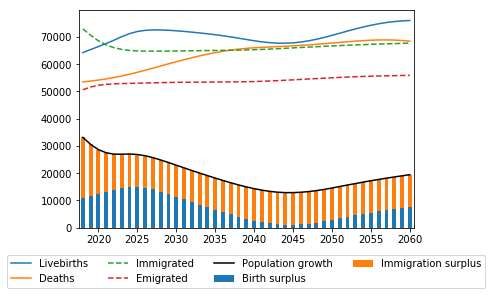

In [10]:
#Plotting birth- and immigration surplus as columns
proj_data[['Birth surplus','Immigration surplus']].plot(kind='bar', stacked=True)

#Plotting the inflow and outflow in the population as line plots
proj_data['Livebirths'].plot()
proj_data['Deaths'].plot()
proj_data['Immigrated'].plot(linestyle='dashed')
proj_data['Emigrated'].plot(linestyle='dashed')

#Plotting the population growth as a line plot.
proj_data['Population growth'].plot(color='k')

#We use the labels for the x-axis computed before
plt.xticks(np.arange(2,len(proj_data),5),aar)

#Putting the legend below the plot and finally showing the plot
plt.legend(bbox_to_anchor=(0.5, -0.3), loc=8, ncol=4)
plt.show()

We see that population growth is slowing down towards 2060. This is especially caused by assuming a lower level of imigration and a lower birth surplus. This stems from the population getting older in average due to a previous baby boom.

# Section 3: Projection of the population size and annual growth

### Below we calculate the annual growth in the projected population along with the population size and average annual growth. For the latter, we use the following formula, where $K_T$ is the end value and $K_1$ is the first value and $T$ is the number of periods:

$ \left( { K_{T} \over K_{1} } \right) ^ {\left(1 \over T \right) } -1$

In [11]:
#Calculating the percentage growth in population annually
proj_data['Relative growth']=proj_data['Population primo'].pct_change()*100

#Calculating the average annual growth
proj_data['Average annual growth (2018-2060)']=((proj_data['Population primo'].iloc[-1]/proj_data['Population primo'].iloc[0])**(1/(2060-2018))-1)*100
proj_data.head()

BEVÆGELSE,TID,Deaths,Emigrated,Immigrated,Livebirths,Population primo,Birth surplus,Immigration surplus,Population growth,Relative growth,Average annual growth (2018-2060)
0,2018,53443,50522,72883,64179,5781190,10736,22361,33097,NaN,0.315224
1,2019,53741,51555,70526,65293,5814283,11552,18971,30523,0.572425,0.315224
2,2020,54104,52194,68509,66378,5844805,12274,16315,28589,0.524949,0.315224
3,2021,54534,52535,67005,67497,5873392,12963,14470,27433,0.489101,0.315224
4,2022,55037,52717,65965,68718,5900824,13681,13248,26929,0.467055,0.315224


### We now plot the calculated predictions

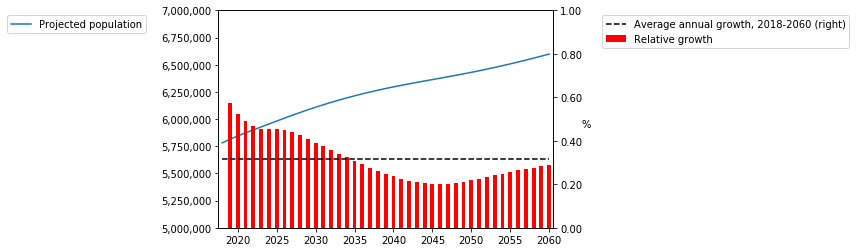

In [8]:
#Plotting annual relative growth and its average as bar plot on the secondary y-axis
ax1=proj_data[['Relative growth']].plot(kind='bar', secondary_y=True,color='red',legend=False, label='Relative growth (right)')
ax2=proj_data['Average annual growth (2018-2060)'].plot(secondary_y=True,color='black',linestyle='dashed', label='Average annual growth, 2018-2060 (right)')

#Plotting the population size on the primary y-axis as a line plot
ax3=proj_data['Population primo'].plot(label = 'Projected population', legend=True)

#Using the computes x-axis tick labels
plt.xticks(np.arange(2,len(proj_data),5),aar)

#Choosing the scale of the y-axis
ax1.set_ylim(0, 1)
ax3.set_ylim(5000000, 7000000)

#Formatting the the y-axis
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_yaxis().set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_ylabel("%",rotation=0,)

#Showing two legends for each y-axis
ax3.legend(bbox_to_anchor=(-0.2,1))
ax1.legend(bbox_to_anchor=(1.9,1))

#Showing the plot
plt.show()

The above illustrates the same point as before, population growth is slowing down.

# Section 4

## Below we will compute an age pyramid, which loops across time in the projection

### We collect and clean the data

In [12]:
#Collecting the data
agedist = Dst.get_data(table_id = 'FRDK118', variables={'HERKOMST':['*'],'KØN':['*'], 'ALDER':['*'], 'TID':['*']})

#As we are not interested in dynamics dependent on origin, we sum on that column.
age_dist=agedist.groupby(['KØN','ALDER','TID'])['INDHOLD'].sum()

#We transpose the DataFrame, such that the dynamics of the projection each are a column
age_dist=age_dist.unstack(level=0)

#We remove the index
age_dist.reset_index(inplace=True)

#We generate a new column, which is equal to the age column. We then remove the 'years' part of the column values
# such that only the age as a number remains. We turn that into an integer column, so we can sort the data
# after that. So the order will be (1, 2, 3, ..) and not (1, 10, 100, 2).
age_dist['Order'] = age_dist['ALDER'].map(lambda x: x.rstrip(' years'))
age_dist['Order']=age_dist['Order'].astype(int)
age_dist.head()

KØN,ALDER,TID,Men,Women,Order
0,0 years,2018,31624.0,30107.0,0
1,0 years,2019,33094.0,31435.0,0
2,0 years,2020,33667.0,31978.0,0
3,0 years,2021,34222.0,32507.0,0
4,0 years,2022,34795.0,33053.0,0


### Computing an x-axis

In [10]:
#We compute labels for the x-axis ticks
alder_list=[0]
next_alder=alder_list[-1]
while next_alder<111:
    next_alder=alder_list[-1]+10
    alder_list.append(next_alder)

### Below we define the functions needed for the age pyramid

In [11]:
# We define a function, that plots the age pyramid for each year, taking the year as an argument
def agedist_plot(age_aar):
    #Selecting the relevant values from the data based on the year.
    agedist_fig=age_dist.loc[age_dist['TID']==age_aar].sort_values(by=['Order'])
    
    #Preparing for a figure with two plots
    fig, axes = plt.subplots(ncols=2, sharey=False)
    
    #First plotting the age distribution for men as a horizontal bar plot.
    axes[0].barh(agedist_fig['ALDER'], agedist_fig['Men'], align='center', color='blue')
    axes[0].set(title='Men')
    
    #Then the same for women.
    axes[1].barh(agedist_fig['ALDER'], agedist_fig['Women'], align='center', color='Red')
    axes[1].set(title='Women')
    
    #The mens horizontal bar plot is mirrored vertically, by inverting its x-axis
    axes[0].invert_xaxis()

    #Setting the x-axis scale
    axes[0].set_xlim(50000)
    axes[1].set_xlim(0,50000)
    
    #Formatting and labeling the x-axis ticks
    axes[1].yaxis.tick_right()
    axes[0].set(yticks=np.arange(0,110,10), yticklabels=agedist_fig['ALDER'][0:-2:10])
    axes[1].set(yticks=np.arange(0,110,10), yticklabels=agedist_fig['ALDER'][0:-2:10])
    
    #Removing the distance between the two plots in the subplot-figure,
    # so it looks like one large figure
    fig.subplots_adjust(wspace=0)
    
    # Displaying the year at the top of the plot
    fig.suptitle(f'Year: {age_aar}')
    
    #Showing the plot
    plt.show()
    return 

#The below function enables the a slider, so the user chooses the year.
# However, this function is not used in this notebook
def interagedist():
    interact(agedist_plot, age_aar = widgets.IntSlider(value=2018, min=2018, max=2058, description='Year:', step=1, disabled=False, continuous=True))

#We define a function, that loops through the years and using them as arguments in the figure function
# It also clears the output at the end of each loop, so it will look like an animation
def loopagedist():
    for age_aar in range(2020,2061,5):
            display.display(agedist_plot(age_aar=age_aar))
            display.clear_output(wait=True);
            #time.sleep(0.0001)

### Plotting the pyramid in a loop.

#### Run the below cell again, to restart the loop.

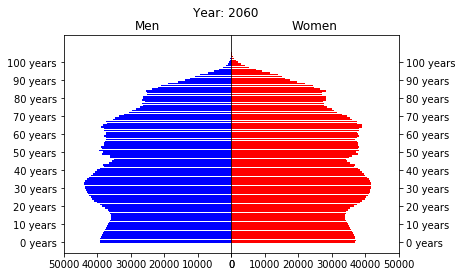

None

In [15]:
#Running the looping function
loopagedist()

From the above animation, we see the baby boom from the 2nd World War having a rippling effect on the age distribution towards 2060.

# Section 5

## Here we compare the Danish, Swedish and Norwegian population growth towards 2060. Using index

### Collecting and cleaning data. The Danish data is from the previously used API and the Swedish and Norwegian data is imported for this notebook

In [13]:
#Creating an empty DateFrame an copying the population size already collected from Denmark Statistics along
# with the year column
pop_DK=pd.DataFrame()
pop_DK=proj_data[['Population primo','TID']].copy()

#Renaming the population size column as 'Denmark'
DK_col={}
DK_col['Population primo'] = 'Danmark'
pop_DK.rename(columns=DK_col, inplace=True)

#Removing the index and setting the year column as index
pop_DK.reset_index(drop=True, inplace=True)
pop_DK.set_index('TID', inplace=True)

#Creating an empty DataFrame and importing the Excel-sheet already downloaded, containing the Swedish
# population projection
pop_SE=pd.DataFrame()
pop_SE=pd.read_excel('dataproject/sverige_pop.xlsx', skiprows=2, col=2,nrows=44)

#Renaming the population size column as 'Sweden'
SE_col={}
SE_col['Unnamed: 0'] = 'TID'
SE_col['total'] = 'Sverige'
pop_SE.rename(columns=SE_col, inplace=True)

# Setting the year column as index
pop_SE.set_index('TID', inplace=True)

#Creating an empty DataFrame and importing the Excel-sheet already downloaded, containing the Norwegian
# population projection
pop_NO=pd.DataFrame()
pop_NO=pd.read_excel('dataproject/norge_pop.xlsx', skiprows=3, col=2)

#Renaming the population size column as 'Norway'
NO_col={}
NO_col['Unnamed: 1'] = 'TID'
NO_col['Population'] = 'Norge'
pop_NO.rename(columns=NO_col, inplace=True)

# Setting the year column as index
pop_NO=pop_NO[['TID','Norge']]
pop_NO.set_index('TID', inplace=True)


# Creating an empy DataFrame
popproj_comp=pd.DataFrame()

# Merging the population projection for each country
popproj_comp=pop_DK.join([pop_SE,pop_NO])

#Creating an empty DataFrame
popind_comp=pd.DataFrame()

#Creating a new column for each country and setting them equal to those of the 
# previously merged DataFrame divided by their respective 2018-size multiplied by 100.
# That way we calculate an index based on the 2018 size
popind_comp['Denmark']=popproj_comp['Danmark']/popproj_comp['Danmark'].iloc[0]*100
popind_comp['Sweden']=popproj_comp['Sverige']/popproj_comp['Sverige'].iloc[0]*100
popind_comp['Norway']=popproj_comp['Norge']/popproj_comp['Norge'].iloc[0]*100

#Renaming the index 
popind_comp.index.names = ['Year']

popind_comp.head()

,Denmark,Sweden,Norway
Year,,,
2018,100.000000,100.000000,100.000000
2019,100.572425,100.949189,100.683471
2020,101.100379,101.918789,101.360219
2021,101.594862,102.884272,102.036041
2022,102.069366,103.784416,102.720588


### Plotting the index plot.

Text(0, 0.5, 'Index 100: 2018')

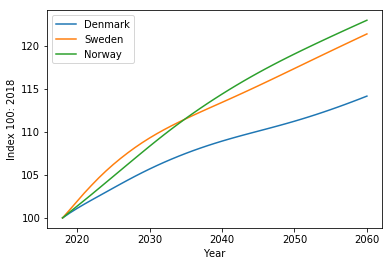

In [14]:
#Plotting the index plot and setting the label for the y-axis
figind=popind_comp.plot()
figind.set_ylabel("Index 100: 2018")

Relative to 2018, the population in Sweden and Norway is projected to grow much faster than in Denmark.